# Introducao

Transformar imagens de cidades para o estilo cyberpunk.

Vou seguir a linha do CycleGAN, pois os problemas com dados pareados para o Pix2Pix contem menos datasets, e acho muito mais interessante o facto de as ser possivel nao usar dados pareados. 

# Import

In [ ]:
import os
import shutil
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import kagglehub
from pprint import pprint

# para nao deixar o pc suspender enquanto treino os modelos
import subprocess
subprocess.run("killall swayidle", shell=True, capture_output=True, text=True)
subprocess.run("killall xss-lock && xset s off -dpms", shell=True, capture_output=True, text=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Datasets

### Cyber images

In [2]:
cyber_dataset_location = os.path.join(kagglehub.dataset_download("aanisha07/futuristic-images"), "Image_Dataset_256")
print(cyber_dataset_location)

/home/ivsopi3/.cache/kagglehub/datasets/aanisha07/futuristic-images/versions/1/Image_Dataset_256


### City images

In [3]:
# move the files out of their folders, prepending the folder name to avoid conflicts
city_dataset_location_1 = os.path.join(kagglehub.dataset_download("vassiliskrikonis/skylines-12"), "data/images")
subfolders = [f for f in os.listdir(city_dataset_location_1) if os.path.isdir(os.path.join(city_dataset_location_1, f))]
for folder in subfolders:
    folder_path = os.path.join(city_dataset_location_1, folder)
    
    # Iterate through files in the subfolder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file
        if os.path.isfile(file_path):
            # Create new filename with folder prefix
            new_filename = f"{folder}_{filename}"
            new_file_path = os.path.join(city_dataset_location_1, new_filename)
            
            # Handle potential filename conflicts
            counter = 1
            base, ext = os.path.splitext(new_filename)
            while os.path.exists(new_file_path):
                new_filename = f"{base}_{counter}{ext}"
                new_file_path = os.path.join(city_dataset_location_1, new_filename)
                counter += 1
            
            # Move the file
            shutil.move(file_path, new_file_path)
            print(f"Moved: {filename} -> {new_filename}")
    
    # Optionally, remove the subfolder if it's empty
    try:
        os.rmdir(folder_path)
        print(f"Removed empty folder: {folder}")
    except OSError:
        print(f"Folder {folder} not empty or could not be removed")

print("Processing city dataset 1 complete.")

print(city_dataset_location_1)



# second dataset
# ignore day images for now
city_dataset_location_2 = os.path.join(kagglehub.dataset_download("sohamndeshmukh/day-night-city-view-dataset"), "data/0")

print(city_dataset_location_2)

Processing city dataset 1 complete.
/home/ivsopi3/.cache/kagglehub/datasets/vassiliskrikonis/skylines-12/versions/2/data/images
/home/ivsopi3/.cache/kagglehub/datasets/sohamndeshmukh/day-night-city-view-dataset/versions/1/data/0


### Image loader

In [4]:
class ImageDataset(Dataset):
    def __init__(self, city_dirs, cyber_dir, transform=None, max_images=None):
        # self.city_dir = city_dir
        # self.cyber_dir = cyber_dir
        self.transform = transform

        self.city_images_path = []
        for city_dir in city_dirs:
            self.city_images_path.extend(
                [os.path.join(city_dir, f) for f in os.listdir(city_dir) if f.endswith(('.jpg', '.png', '.JPG', '.jpeg'))]
            )
        self.cyber_images_path = [os.path.join(cyber_dir, f) for f in os.listdir(cyber_dir) if f.endswith(('.jpg', '.png', '.JPG', '.jpeg'))]

        # datasets are unbalanced, so limit them by max_images and by the smaller dataset to ensure both have the same number of images
        self.size = min(len(self.city_images_path), len(self.cyber_images_path))
        if max_images:
            self.size = min(self.size, max_images)

        # 10k images should fit in memory, otherwise training is slower
        # idk if DataLoader already preloads things so I'll do it manually
        city_images = []
        cyber_images = []
        print("Preloading images")
        for i in range(self.size):
            try:
                if i % (self.size // 10) == 0:
                    percentage = (i / self.size) * 100
                    print(f"Progress: {percentage:.0f}%")
                city_img = Image.open(self.city_images_path[i]).convert('RGB')
                cyber_img = Image.open(self.cyber_images_path[i]).convert('RGB')
                city_images.append(city_img)
                cyber_images.append(cyber_img)
            except Exception as e:
                print(f"Error at image {i}: {e}, skipping")
                self.size -= 1 # if any image has an error, both are skipped to ensure it still stays balanced
                continue

        self.city_images = city_images
        self.cyber_images = cyber_images
        print(f"loaded {self.size} images from each dataset (city has {len(self.city_images_path)} and cyber has {len(self.cyber_images_path)})")



    def __len__(self):
        return self.size

    # open imgs as rgb, transform if needed. transform is dynamic so it's easier to randomize
    def __getitem__(self, idx):
        city_img = self.city_images[idx]
        cyber_img = self.cyber_images[idx]
        if self.transform:
            city_img = self.transform(city_img)
            cyber_img = self.transform(cyber_img)
        return {'city': city_img, 'cyber': cyber_img}


### Generator - CycleGAN
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [5]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels = 3, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

### Generator - PatchGAN

https://paperswithcode.com/method/patchgan mas mudei para 3 channels em vez dos 6 do pix2pix, onde 2 imagens de 3 canais são concatenadas. Não faz sentido usar aqui, mas não custa experimentar

Não converti o discriminator porque precisa de labels e imagens pareadas

In [6]:
class GeneratorPatchGAN(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(GeneratorPatchGAN, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


### Discriminators - CycleGAN
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/

In [7]:
# inspired from CycleGAN https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Training

### Load data. Split into training and testing

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageDataset([city_dataset_location_1, city_dataset_location_2], cyber_dataset_location, transform=transform, max_images=500)
# without splitting
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # No shuffle for testing

Preloading images
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 29%
Progress: 39%
Progress: 49%
Progress: 59%
Progress: 69%
Progress: 78%
Progress: 88%
Progress: 98%
loaded 347 images from each dataset (city has 347 and cyber has 572)


### Training loop

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

def train(name, criterion_GAN, criterion_cycle, criterion_identity, device, epochs=100, lr=0.0002, save_dir='output'):

    # create generators and discriminators inside the scope of the function, they are meant to be saved and loaded, not reused directly
    gen_City2Cyber = Generator().to(device)
    gen_Cyber2City = Generator().to(device)
    disc_City = Discriminator().to(device)
    disc_Cyber = Discriminator().to(device)

    # Optimizers
    optimizer_G = optim.Adam(list(gen_City2Cyber.parameters()) + list(gen_Cyber2City.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_City = optim.Adam(disc_City.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_Cyber = optim.Adam(disc_Cyber.parameters(), lr=lr, betas=(0.5, 0.999))
    
    os.makedirs(save_dir, exist_ok=True)
    
    # store total losses for plotting
    losses = {
        'G': [], 'D_City': [], 'D_Cyber': [],
        'GAN_City2Cyber': [], 'GAN_Cyber2City': [],
        'Cycle': [], 'Identity': [],
        'D_real_City': [], 'D_fake_City': [],
        'D_real_Cyber': [], 'D_fake_Cyber': []
    }
    
    for epoch in range(epochs):
        epoch_losses = {key: 0.0 for key in losses}
        num_batches = 0
        
        loop = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", unit="batch")
        
        for i, data in enumerate(loop):
            real_City = data['city'].to(device)
            real_Cyber = data['cyber'].to(device)
            
            # Ground truth for discriminators
            real_label = torch.ones(real_City.size(0), 1, 30, 30).to(device)  # PatchGAN output size
            fake_label = torch.zeros(real_City.size(0), 1, 30, 30).to(device)
            
            ########## Train Generators ##########
            optimizer_G.zero_grad()
            
            # Identity loss
            identity_City = gen_Cyber2City(real_City)
            identity_Cyber = gen_City2Cyber(real_Cyber)
            loss_identity = (criterion_identity(identity_City, real_City) + criterion_identity(identity_Cyber, real_Cyber)) * 5.0
            
            # GAN loss
            fake_Cyber = gen_City2Cyber(real_City)  # Changed variable name for clarity
            pred_fake_Cyber = disc_Cyber(fake_Cyber)
            loss_GAN_City2Cyber = criterion_GAN(pred_fake_Cyber, real_label)
            
            fake_City = gen_Cyber2City(real_Cyber)
            pred_fake_City = disc_City(fake_City)
            loss_GAN_Cyber2City = criterion_GAN(pred_fake_City, real_label)
            
            # Cycle consistency loss
            rec_City = gen_Cyber2City(fake_Cyber)
            rec_Cyber = gen_City2Cyber(fake_City)
            loss_cycle = (criterion_cycle(rec_City, real_City) + criterion_cycle(rec_Cyber, real_Cyber)) * 10.0
            
            # Total generator loss
            loss_G = loss_GAN_City2Cyber + loss_GAN_Cyber2City + loss_cycle + loss_identity
            loss_G.backward()
            optimizer_G.step()
            
            ########## Train Discriminators ##########
            # City
            optimizer_D_City.zero_grad()
            pred_real_City = disc_City(real_City)
            loss_D_real_City = criterion_GAN(pred_real_City, real_label)
            pred_fake_City = disc_City(fake_City.detach())
            loss_D_fake_City = criterion_GAN(pred_fake_City, fake_label)
            loss_D_City = (loss_D_real_City + loss_D_fake_City) * 0.5
            loss_D_City.backward()
            optimizer_D_City.step()
            
            # Cyber
            optimizer_D_Cyber.zero_grad()
            pred_real_Cyber = disc_Cyber(real_Cyber)
            loss_D_real_Cyber = criterion_GAN(pred_real_Cyber, real_label)
            pred_fake_Cyber = disc_Cyber(fake_Cyber.detach())  # Fixed: Use fake_Cyber
            loss_D_fake_Cyber = criterion_GAN(pred_fake_Cyber, fake_label)
            loss_D_Cyber = (loss_D_real_Cyber + loss_D_fake_Cyber) * 0.5
            loss_D_Cyber.backward()
            optimizer_D_Cyber.step()
            
            # Accumulate losses
            batch_losses = {
                'G': loss_G.item(),
                'D_City': loss_D_City.item(),
                'D_Cyber': loss_D_Cyber.item(),
                'GAN_City2Cyber': loss_GAN_City2Cyber.item(),
                'GAN_Cyber2City': loss_GAN_Cyber2City.item(),
                'Cycle': loss_cycle.item(),
                'Identity': loss_identity.item(),
                'D_real_City': loss_D_real_City.item(),
                'D_fake_City': loss_D_fake_City.item(),
                'D_real_Cyber': loss_D_real_Cyber.item(),
                'D_fake_Cyber': loss_D_fake_Cyber.item()
            }
            
            for key in epoch_losses:
                epoch_losses[key] += batch_losses[key]
            
            num_batches += 1
            
            # Update progress bar
            loop.set_postfix(**{k: v/num_batches for k, v in batch_losses.items()})
            
            # Save example images every 1000 batches
            if i % 1000 == 0:
                with torch.no_grad():
                    fake_Cyber_img = gen_City2Cyber(real_City)
                    fake_City_img = gen_Cyber2City(real_Cyber)
                    img_cyber = fake_Cyber_img[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
                    img_city = fake_City_img[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
                    plt.imsave(os.path.join(save_dir, f'epoch_{epoch+1}_batch_{i}_fake_cyber.png'), img_cyber)
                    plt.imsave(os.path.join(save_dir, f'epoch_{epoch+1}_batch_{i}_fake_city.png'), img_city)
        
        # Compute average losses
        avg_losses = {key: val/num_batches for key, val in epoch_losses.items()}
        
        # Append to loss history
        for key in losses:
            losses[key].append(avg_losses[key])
        
        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Summary: "
              f"Loss_G: {avg_losses['G']:.4f}, Loss_D_City: {avg_losses['D_City']:.4f}, Loss_D_Cyber: {avg_losses['D_Cyber']:.4f}, "
              f"GAN_City2Cyber: {avg_losses['GAN_City2Cyber']:.4f}, GAN_Cyber2City: {avg_losses['GAN_Cyber2City']:.4f}, "
              f"Cycle: {avg_losses['Cycle']:.4f}, Identity: {avg_losses['Identity']:.4f}")
        
        # Plot losses
        plt.figure(figsize=(12, 8))
        for key in losses:
            plt.plot(losses[key], label=key)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves at Epoch {epoch+1}')
        plt.savefig(os.path.join(save_dir, f'loss_curves_epoch_{epoch+1}.png'))
        plt.close()
        
        # Save models every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(gen_City2Cyber.state_dict(), os.path.join(save_dir, f'{name}_gen_City2Cyber.pth'))
            torch.save(gen_Cyber2City.state_dict(), os.path.join(save_dir, f'{name}_gen_Cyber2City.pth'))
            torch.save(disc_City.state_dict(), os.path.join(save_dir, f'{name}_disc_City.pth'))
            torch.save(disc_Cyber.state_dict(), os.path.join(save_dir, f'{name}_disc_Cyber.pth'))
            print(f"Saved models at epoch {epoch+1}")
    
    # Return loss history for further analysis
    return losses

### Define the different models

To make things easier, I make each model be defined by a dictionary in a list

So each model has its own loss functions so I can easily compare them

In [10]:
models = []

models.append(
    {
        "name": "0",
        "criterion_GAN": nn.MSELoss(),
        "criterion_cycle": nn.L1Loss(),
        "criterion_identity": nn.L1Loss(),
        "training_losses": None
    }
)

models.append(
    {
        "name": "1",
        "criterion_GAN": nn.BCEWithLogitsLoss(),
        "criterion_cycle": nn.L1Loss(),
        "criterion_identity": nn.L1Loss(),
        "training_losses": None
    }
)

### Train models with different loss functions

In [ ]:
for model in models:
    print(f"Training model {model}")
    model["training_losses"] = train("0", model["criterion_GAN"], model["criterion_cycle"], model["criterion_identity"], device, epochs=5, lr=0.0002, save_dir='output')

Training model {'name': '0', 'criterion_GAN': MSELoss(), 'criterion_cycle': L1Loss(), 'criterion_identity': L1Loss(), 'training_losses': None}


Epoch [1/5]:  82%|████████▏ | 228/277 [00:42<00:08,  5.50batch/s, Cycle=0.0277, D_City=0.000614, D_Cyber=0.00177, D_fake_City=0.000605, D_fake_Cyber=0.000374, D_real_City=0.000623, D_real_Cyber=0.00316, G=0.046, GAN_City2Cyber=0.00255, GAN_Cyber2City=0.00214, Identity=0.0136]   

### Plot losses

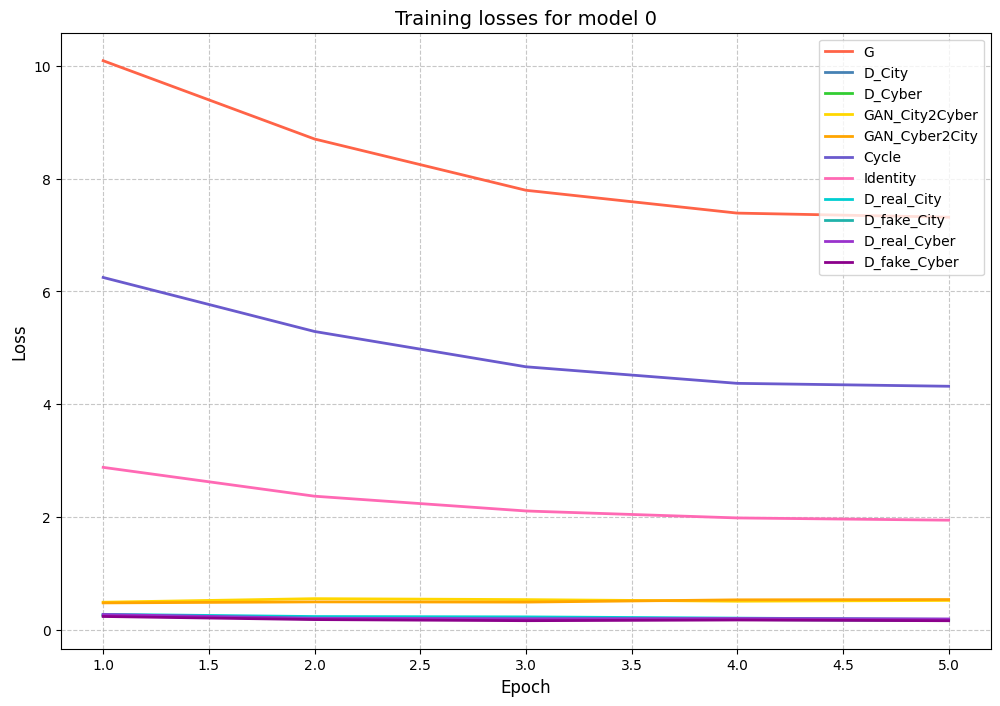

In [ ]:
def plot_losses(losses, name):
    colors = {
        'G': '#FF6347',
        'D_City': '#4682B4',
        'D_Cyber': '#32CD32',
        'GAN_City2Cyber': '#FFD700',
        'GAN_Cyber2City': '#FFA500',
        'Cycle': '#6A5ACD',
        'Identity': '#FF69B4',
        'D_real_City': '#00CED1',
        'D_fake_City': '#20B2AA',
        'D_real_Cyber': '#9932CC',
        'D_fake_Cyber': '#8B008B'
    }
    
    plt.figure(figsize=(12, 8))
    
    for loss_name, loss_values in losses.items():
        if loss_values:
            plt.plot(range(1, len(loss_values) + 1), loss_values, 
                    label=loss_name, color=colors.get(loss_name, '#000000'), 
                    linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f"Training losses for model {name}", fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

for model in models:
    plot_losses(model["training_losses"], model["name"])

# Infer and evaluate, using test data and models from file

### Load each model from its file

In [ ]:


for model in models:
    gen_City2Cyber = Generator().to(device)
    gen_Cyber2City = Generator().to(device)
    disc_City = Discriminator().to(device)
    disc_Cyber = Discriminator().to(device)

    gen_City2Cyber.load_state_dict(torch.load(f"output/{model["name"]}_gen_City2Cyber.pth", map_location=device))
    gen_Cyber2City.load_state_dict(torch.load(f"output/{model["name"]}_gen_Cyber2City.pth", map_location=device))
    disc_City.load_state_dict(torch.load(f"output/{model["name"]}_disc_City.pth", map_location=device))
    disc_Cyber.load_state_dict(torch.load(f"output/{model["name"]}_disc_Cyber.pth", map_location=device))

    # set them to eval mode
    gen_City2Cyber.eval()
    gen_Cyber2City.eval()
    disc_Cyber.eval()
    disc_City.eval()

    model["gen_City2Cyber"] = gen_City2Cyber
    model["gen_Cyber2City"] = gen_Cyber2City
    model["disc_Cyber"] = disc_Cyber
    model["disc_City"] = disc_City



In [ ]:
def evaluate_model(dataloader, model, device, lambda_cycle=10.0, lambda_identity=5.0):
    criterion_GAN = model["criterion_GAN"]
    criterion_cycle = model["criterion_cycle"]
    criterion_identity = model["criterion_identity"]
    gen_City2Cyber = model["gen_City2Cyber"]
    gen_Cyber2City = model["gen_Cyber2City"]
    disc_Cyber = model["disc_Cyber"]
    disc_City = model["disc_City"]
    
    total_generator_loss = 0
    total_discriminator_loss = 0
    total_gan_loss = 0
    total_cycle_loss = 0
    total_identity_loss = 0
    total_d_real_loss = 0
    total_d_fake_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            real_city = batch['city'].to(device, non_blocking=True)
            real_cyber = batch['cyber'].to(device, non_blocking=True)
            
            real_label = torch.ones(real_city.size(0), 1, 30, 30).to(device)
            fake_label = torch.zeros_like(real_label)
            
            fake_cyber = gen_City2Cyber(real_city)
            
            identity_city = gen_City2Cyber(real_city)
            loss_identity = criterion_identity(identity_city, real_city) * lambda_identity
            
            pred_fake_cyber = disc_Cyber(fake_cyber)
            loss_gan_city2cyber = criterion_GAN(pred_fake_cyber, real_label)
            
            rec_city = gen_Cyber2City(fake_cyber)
            loss_cycle = criterion_cycle(rec_city, real_city) * lambda_cycle
            
            loss_g = loss_gan_city2cyber + loss_cycle + loss_identity
            
            pred_real_cyber = disc_Cyber(real_cyber)
            loss_d_real_cyber = criterion_GAN(pred_real_cyber, real_label)
            pred_fake_cyber = disc_Cyber(fake_cyber.detach())
            loss_d_fake_cyber = criterion_GAN(pred_fake_cyber, fake_label)
            loss_d_cyber = (loss_d_real_cyber + loss_d_fake_cyber) * 0.5
            
            total_generator_loss += loss_g.item()
            total_discriminator_loss += loss_d_cyber.item()
            total_gan_loss += loss_gan_city2cyber.item()
            total_cycle_loss += loss_cycle.item()
            total_identity_loss += loss_identity.item()
            total_d_real_loss += loss_d_real_cyber.item()
            total_d_fake_loss += loss_d_fake_cyber.item()
            num_batches += 1
    
    # Compute average losses
    avg_losses = {
        'test_generator_loss': total_generator_loss / num_batches,
        'test_discriminator_loss': total_discriminator_loss / num_batches,
        'test_gan_loss': total_gan_loss / num_batches,
        'test_cycle_loss': total_cycle_loss / num_batches,
        'test_identity_loss': total_identity_loss / num_batches,
        'test_d_real_loss': total_d_real_loss / num_batches,
        'test_d_fake_loss': total_d_fake_loss / num_batches
    }
    
    return avg_losses

def infer_cyclegan(input_dir, model, device):
    criterion_GAN = model["criterion_GAN"]
    criterion_cycle = model["criterion_cycle"]
    criterion_identity = model["criterion_identity"]
    gen_City2Cyber = model["gen_City2Cyber"]
    gen_Cyber2City = model["gen_Cyber2City"]
    disc_Cyber = model["disc_Cyber"]
    disc_City = model["disc_City"]

    # Define image transforms (must match training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
   
    
    # Get list of input images
    input_images = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
    
    # Process each image
    for img_path in input_images:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
        
        # Generate cyber-style image
        with torch.no_grad():
            fake_cyber = gen_City2Cyber(img_tensor)
        
        # Denormalize and convert to PIL image for generated output
        fake_cyber = fake_cyber.squeeze(0).cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fake_cyber = (fake_cyber * 255).astype(np.uint8)
        output_img = Image.fromarray(fake_cyber)
        
        # Denormalize and convert transformed input tensor to PIL image
        transformed_img = img_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        transformed_img = (transformed_img * 255).astype(np.uint8)
        transformed_img = Image.fromarray(transformed_img)
        
        # Display input, transformed, and output
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original (City)")
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title("Transformed Input")
        plt.imshow(transformed_img)
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title("Output (Cyber)")
        plt.imshow(output_img)
        plt.axis('off')
        plt.show()



### Evaluate the losses of each model using the test dataset

In [ ]:
for model in models:
    test_losses = evaluate_model(test_dataloader, model, device)
    print(f"Model {model["name"]} has test losses")
    pprint(test_losses, indent=4)


Model 0 has test losses
{   'test_cycle_loss': 1.9858031945569175,
    'test_d_fake_loss': 0.14040527985032117,
    'test_d_real_loss': 0.3200737972344671,
    'test_discriminator_loss': 0.2302395382097789,
    'test_gan_loss': 0.5560287186077663,
    'test_generator_loss': 4.319571372440883,
    'test_identity_loss': 1.7777394567217146}


### Generate images from each model

Generating images from model 0


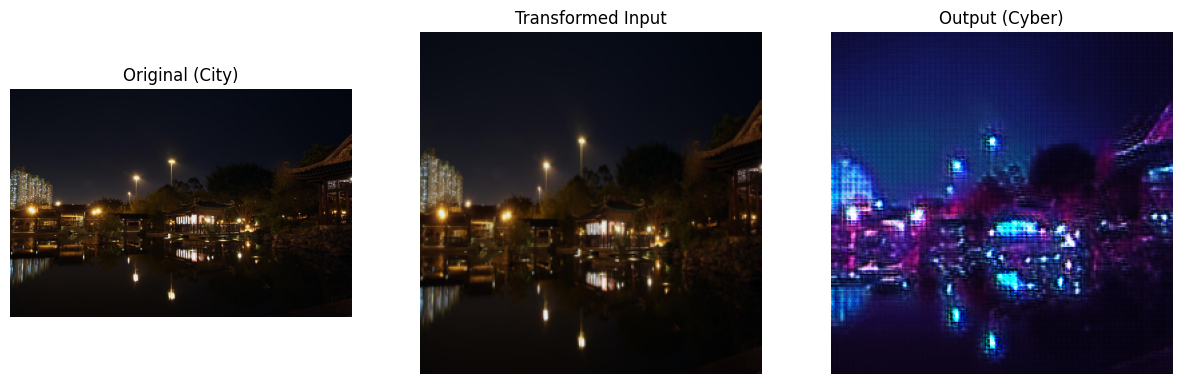

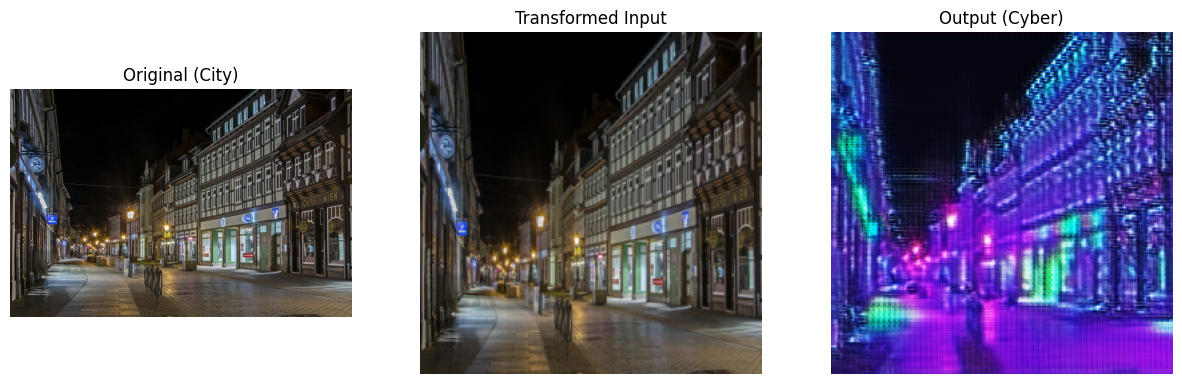

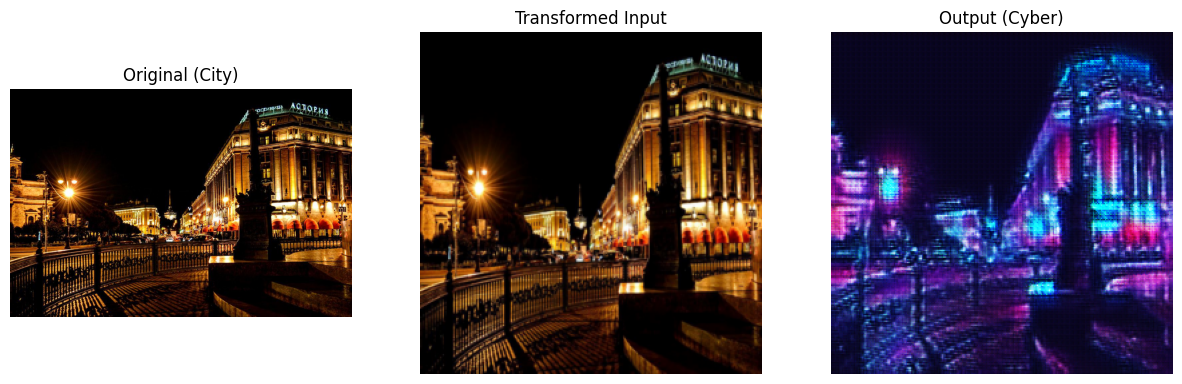

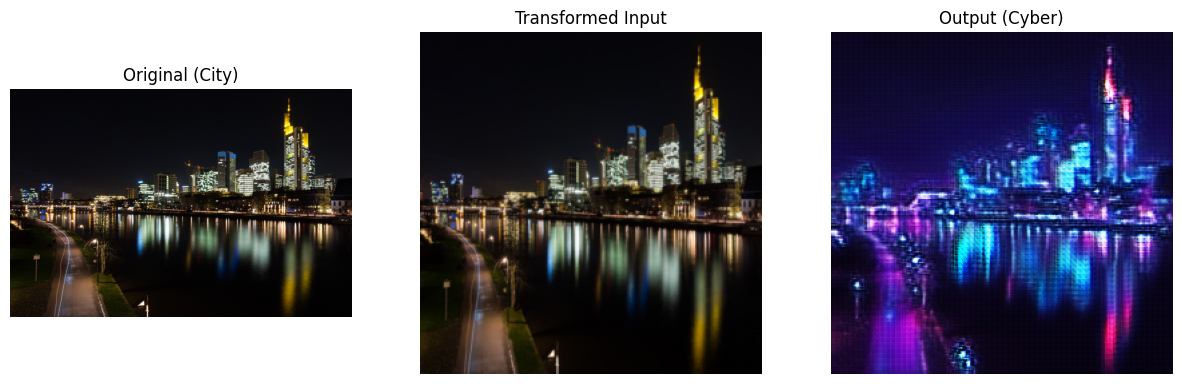

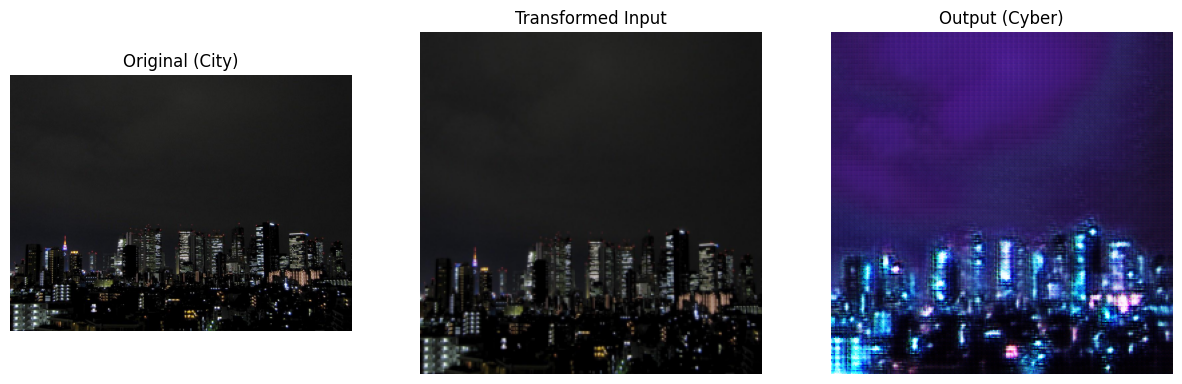

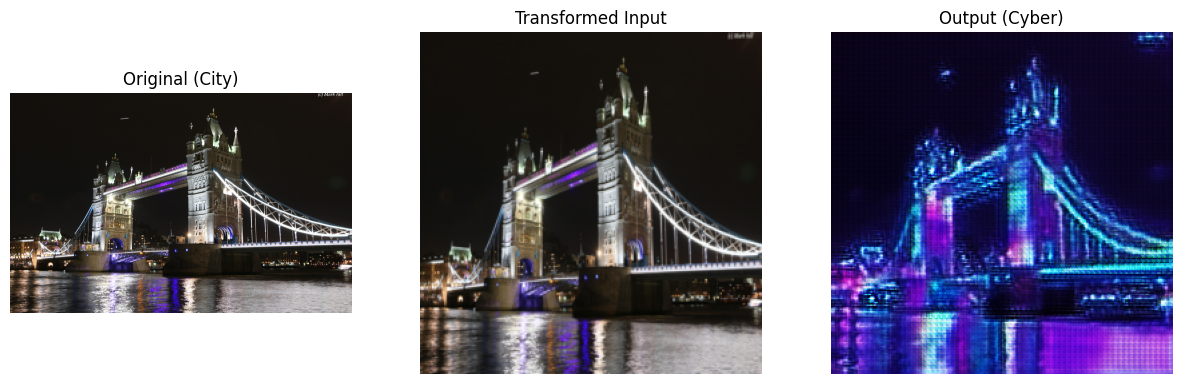

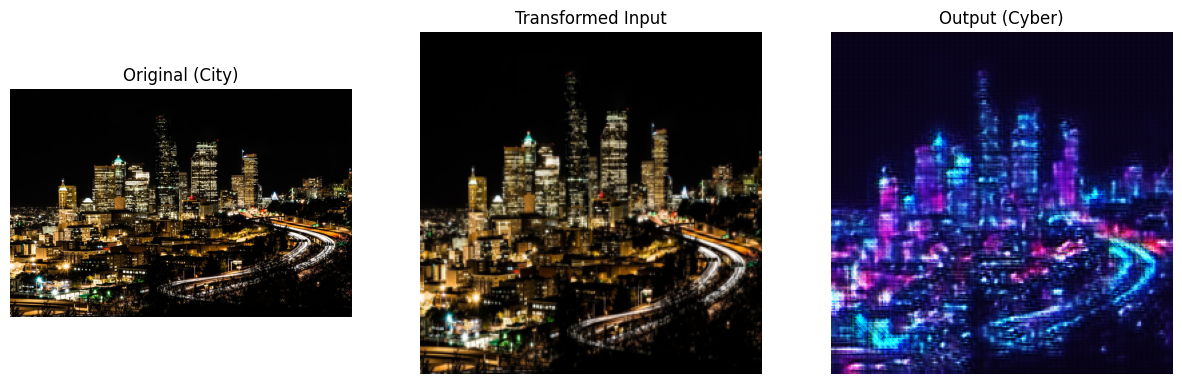

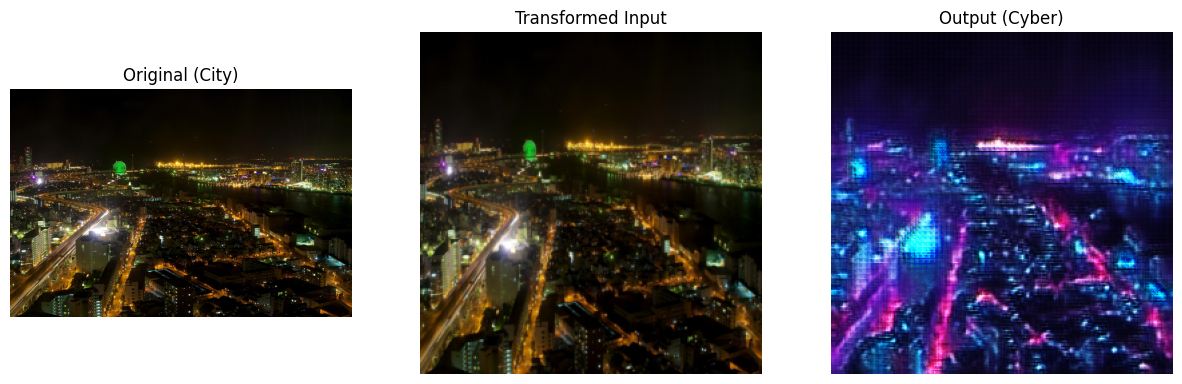

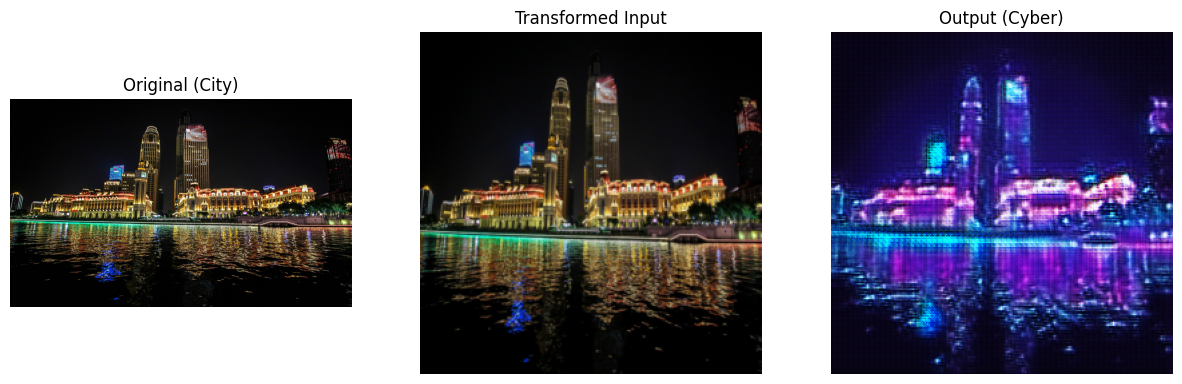

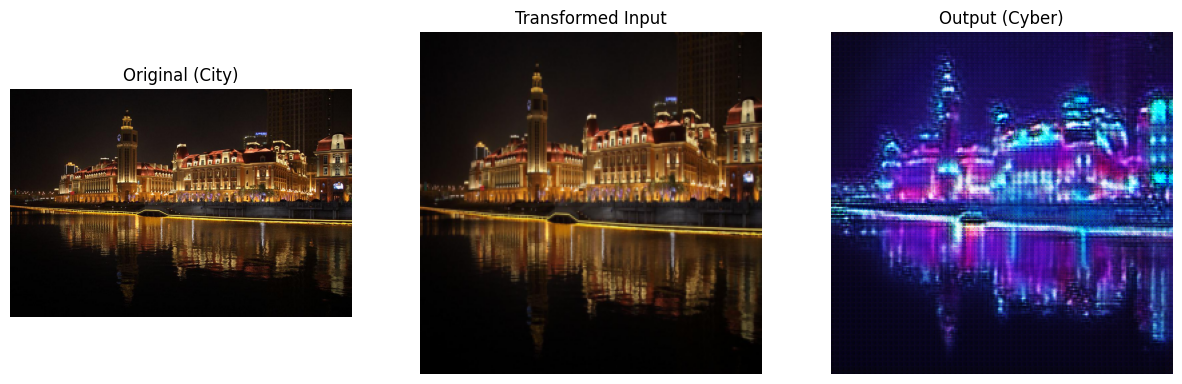

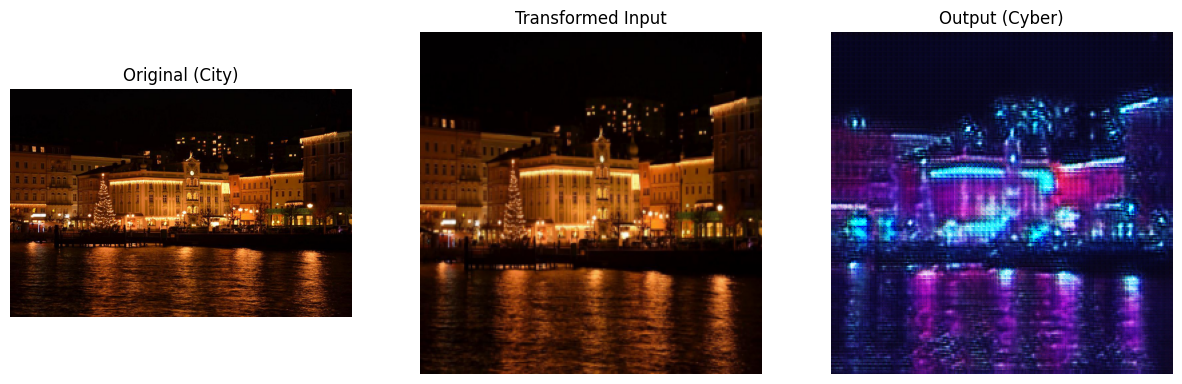

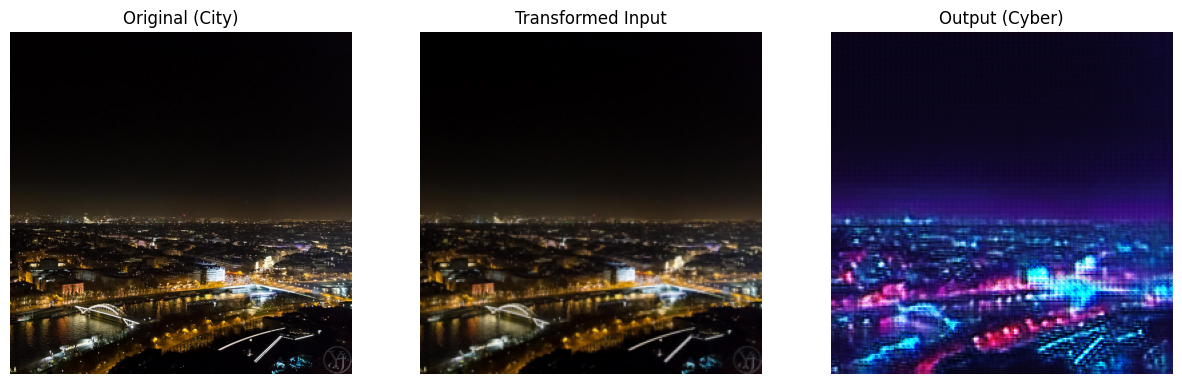

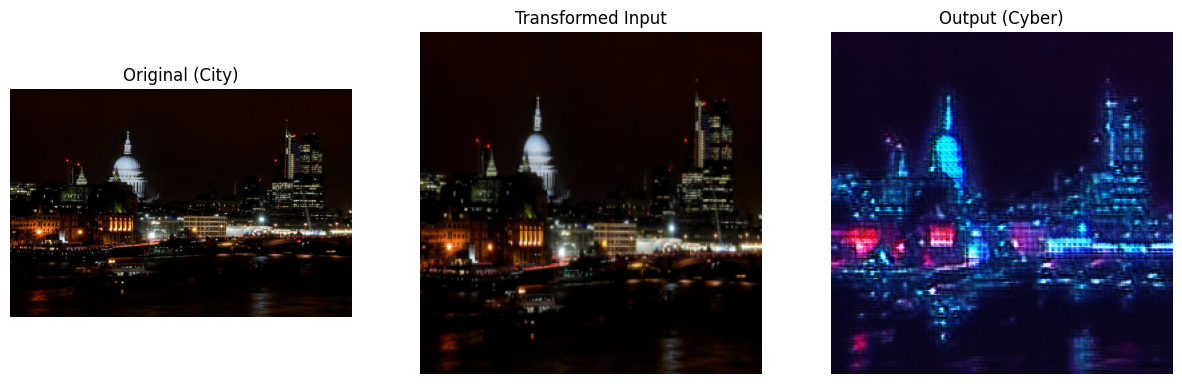

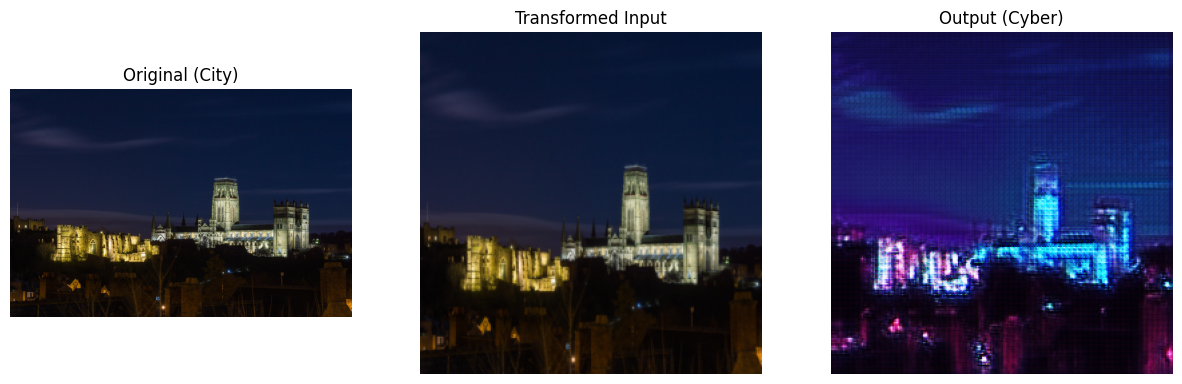

In [ ]:
for model in models:
    print(f"Generating images from model {model["name"]}")
    infer_cyclegan("input", model, device)